In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
from tifffile import imread
from skimage import draw

In [12]:
train_dir, test_dir = 'train/', 'test/'
# print(os.getcwd())

ntrain, ntest = len(os.listdir(train_dir)), len(os.listdir(test_dir))
print(f'Total number of training images is {ntrain}, Total number of testing images is {ntest}')
#training images = 220025, #test inages=57458

Total number of training images is 220025, Total number of testing images is 57458


Next let us take a look at the traning lables

In [14]:
train_df = pd.read_csv('train_labels.csv')
train_df['label'] = train_df['label'].astype(str)
train_df['id'] = train_df['id'] + '.tif'
train_df.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7.tif,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif,1
8,559e55a64c9ba828f700e948f6886f4cea919261.tif,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif,0


We know am image is represented by picel values. Next we check what is the array looks like for an image

In [4]:
print(f'Image array is represented by:  {imread(f"{train_dir}/{train_df.id[0]}").shape}')

Image array is represented by:  (96, 96, 3)


In [5]:
def plot_images(df, label, n=36):
    df_sub = df.loc[df.label == label].sample(n)
    imfiles = df_sub['id'].values
    plt.figure(figsize=(8,8))
    for i in range(n):
        im = imread(f'{train_dir}/{imfiles[i]}')
        plt.subplot(6,6,i+1)
        plt.imshow(im)
        plt.axis('off')
    plt.suptitle(f'images with label = {label}', size=10)
    plt.tight_layout()
    plt.show()

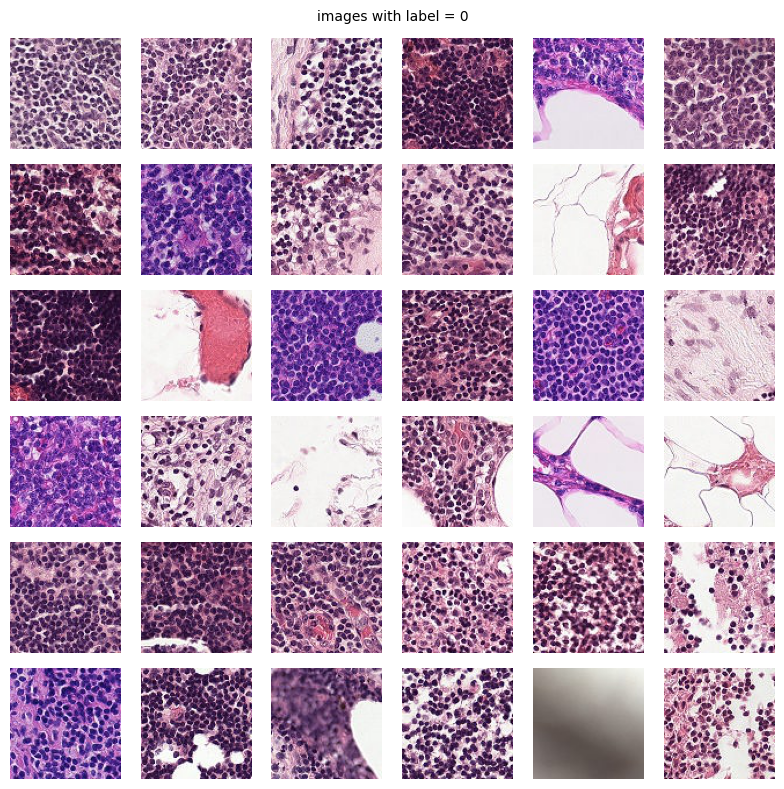

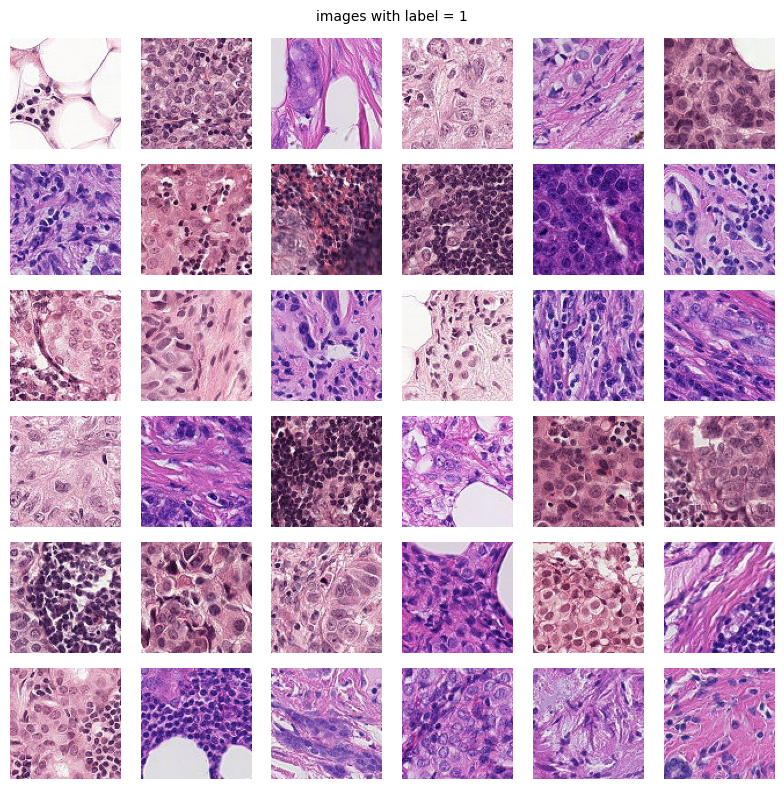

In [6]:
for label in train_df.label.unique():
    plot_images(train_df, label)

In [4]:
batch_size = 256
im_size = (96,96)
 
generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)
 
train_data = generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)
 
validate_data = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=train_dir,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=im_size)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [9]:
def make_plt(hist):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history['val_accuracy'])
    plt.legend(["Model Training Accuracy","Model Validation Accuracy"])
    plt.ylabel("Accuracy Percentage")
    plt.xlabel("Epoch")
    plt.grid()
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.ylabel("Loss Percentage")
    plt.xlabel("Epoch")
    plt.grid()
    plt.legend(["Loss in Training set","Loss in Validation Set"])
    plt.tight_layout()
    plt.show()

In [5]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, n_filter, kernel_sz=(3,3), activation='relu', pool_sz=(2,2), batch_norm=False):
        super(ConvBlock, self).__init__()
        self.batch_norm = batch_norm
        self.conv_1 = Conv2D(n_filter, kernel_sz, activation=activation)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(n_filter, kernel_sz, activation=activation)
        self.bn_2 = BatchNormalization()
        self.pool = MaxPool2D(pool_size=pool_sz)
 
    def call(self, x):
        x = self.conv_1(x)
        if self.batch_norm:
          x = self.bn_1(x)
          x = tf.keras.layers.ReLU()(x)
        x = self.conv_2(x)
        if self.batch_norm:
          x = self.bn_2(x)
          x = tf.keras.layers.ReLU()(x)
        return self.pool(x)


class FirstBlock(tf.keras.layers.Layer):
    def __init__(self, n_units=256, activation='relu', drop_out=False, drop_rate=0.5):
        # initialize the block with configurable hyperparameter values, e.g., number of neurons in Dense block, activation
        # Droput present or not
        super(FirstBlock, self).__init__()
        self.drop_out = drop_out
        self.flat  = tf.keras.layers.Flatten()
        self.dropout = Dropout(drop_rate)
        self.dense = tf.keras.layers.Dense(n_units, activation=activation)
        self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')
 
    def call(self, x, training=False):
        # forward pass
        x = self.flat(x)
        #if training:
        #  x = self.dropout(x)
        x = self.dense(x)
        return self.classifier(x)

In [6]:
class CNNModel1(tf.keras.Model):
    def __init__(self, input_shape=(im_size,im_size,3), n_class=1):
        super(CNNModel1, self).__init__()
        # the first conv module
        self.conv_block_1 = ConvBlock(16)
        # the second conv module
        self.conv_block_2 = ConvBlock(32)
        # model top
        self.top_block = FirstBlock(n_units=256)
 
    def call(self, inputs, training=False, **kwargs):
        # forward pass 
        x = self.conv_block_1(inputs)
        x = self.conv_block_2(x)
        return self.top_block(x)       
 

model1 = CNNModel1()
model1.build(input_shape=(batch_size,im_size[0],im_size[1],3))
model1.summary()

2023-12-13 14:56:48.564465: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-13 14:56:48.564484: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-13 14:56:48.564489: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-13 14:56:48.564515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 14:56:48.564530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "cnn_model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  2768      
                                                                 
 conv_block_1 (ConvBlock)    multiple                  13888     
                                                                 
 first_block (FirstBlock)    multiple                  3613185   
                                                                 
Total params: 3629841 (13.85 MB)
Trainable params: 3629841 (13.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(im_size[0],im_size[1],3), 
    include_top=False, 
    weights='imagenet'
)

2023-12-13 10:02:56.368817: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-13 10:02:56.368899: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-13 10:02:56.368914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-13 10:02:56.368994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-13 10:02:56.369030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
np.random.seed(1)
tf.random.set_seed(1)
 
model_resnet50 = Sequential([
    base_model,
    Flatten(),    
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
], 'resnet50_backbone')
 
model_resnet50.summary()
 

Model: "resnet50_backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 16)                131088    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                 

In [8]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.001)
model_resnet50.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
 
hist2 = model_resnet50.fit(train_data, validation_data=validate_data, epochs=5, verbose=1)

Epoch 1/5


2023-12-13 10:03:09.669314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-13 10:03:10.230664: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


645/645 [==============================] - 279s 414ms/step - loss: 0.3520 - accuracy: 0.8585 - auc: 0.9220 - val_loss: 1.2858 - val_accuracy: 0.5955 - val_auc: 0.4567
Epoch 2/5
645/645 [==============================] - 260s 403ms/step - loss: 0.2653 - accuracy: 0.8984 - auc: 0.9554 - val_loss: 0.5531 - val_accuracy: 0.8108 - val_auc: 0.9242
Epoch 3/5
645/645 [==============================] - 260s 403ms/step - loss: 0.2320 - accuracy: 0.9137 - auc: 0.9654 - val_loss: 0.9286 - val_accuracy: 0.7813 - val_auc: 0.8312
Epoch 4/5
645/645 [==============================] - 261s 404ms/step - loss: 0.2086 - accuracy: 0.9242 - auc: 0.9718 - val_loss: 0.7718 - val_accuracy: 0.7893 - val_auc: 0.9237
Epoch 5/5
645/645 [==============================] - 259s 401ms/step - loss: 0.1903 - accuracy: 0.9299 - auc: 0.9765 - val_loss: 1.2485 - val_accuracy: 0.7165 - val_auc: 0.7071


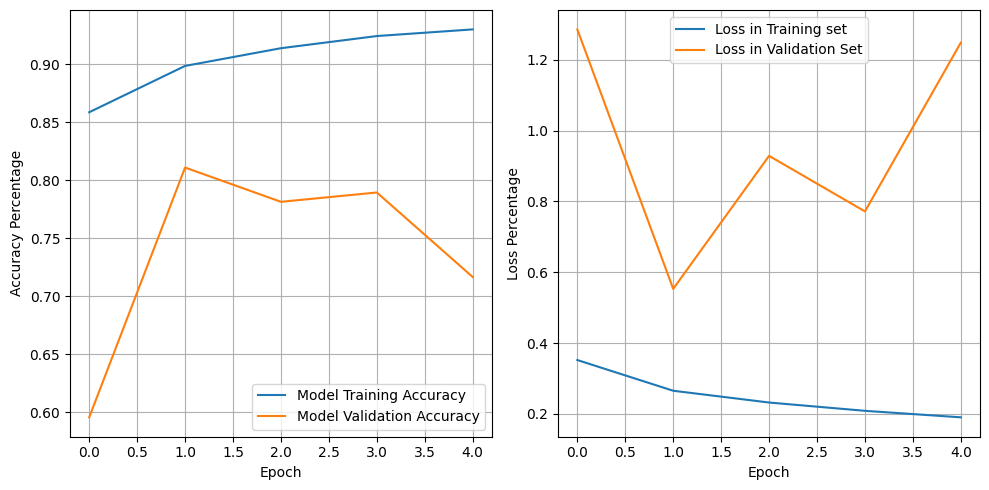

In [11]:
make_plt(hist2)

In [7]:
opt = Adam(learning_rate=0.0001)
model1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
hist = model1.fit(train_data, validation_data=validate_data, epochs=10)

Epoch 1/10


2023-12-13 14:57:02.711087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-13 14:57:02.745307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


645/645 [==============================] - 97s 150ms/step - loss: 0.4758 - accuracy: 0.7770 - val_loss: 0.4411 - val_accuracy: 0.7981
Epoch 2/10
645/645 [==============================] - 94s 146ms/step - loss: 0.4304 - accuracy: 0.8057 - val_loss: 0.4340 - val_accuracy: 0.7980
Epoch 3/10
645/645 [==============================] - 91s 141ms/step - loss: 0.4110 - accuracy: 0.8163 - val_loss: 0.4089 - val_accuracy: 0.8217
Epoch 4/10
645/645 [==============================] - 93s 144ms/step - loss: 0.3996 - accuracy: 0.8219 - val_loss: 0.3954 - val_accuracy: 0.8220
Epoch 5/10
645/645 [==============================] - 95s 147ms/step - loss: 0.3864 - accuracy: 0.8296 - val_loss: 0.3784 - val_accuracy: 0.8359
Epoch 6/10
645/645 [==============================] - 93s 143ms/step - loss: 0.3790 - accuracy: 0.8334 - val_loss: 0.3756 - val_accuracy: 0.8361
Epoch 7/10
645/645 [==============================] - 100s 155ms/step - loss: 0.4860 - accuracy: 0.7874 - val_loss: 0.4178 - val_accuracy: 0.

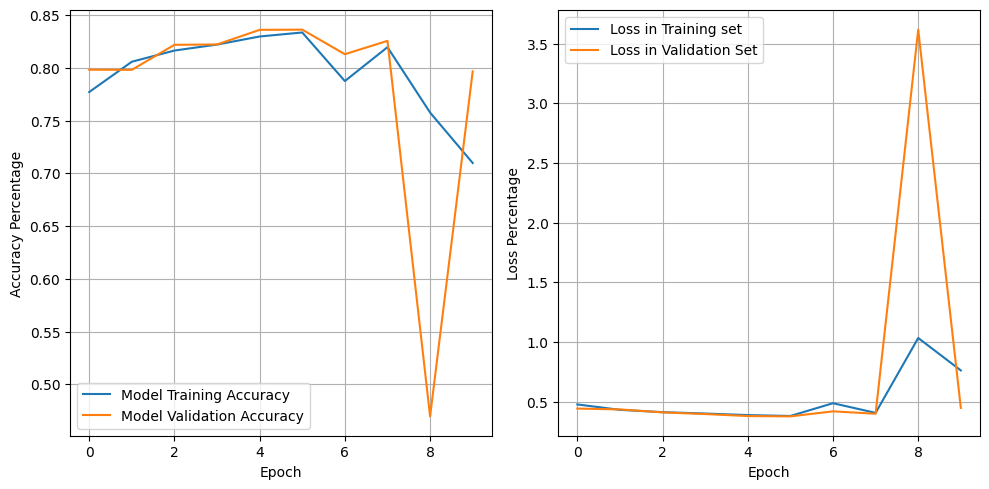

In [11]:
make_plt(hist)

In [26]:
images_test = pd.DataFrame({'id':os.listdir(test_dir)})
generator_test = ImageDataGenerator(rescale=1./255) # scale the test images to have pixel values in [0-1]
 
test_data = generator_test.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', # filenames
    directory=test_dir,
    class_mode=None,
    batch_size=1,
    target_size=im_size,
    shuffle=False)
 
predictions = model1.predict(test_data, verbose=1)
 
predictions = predictions.squeeze()
predictions.shape
 
submission_df = pd.DataFrame()
submission_df['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))
 
submission_df['label'].value_counts()
submission_df.to_csv('submission_final.csv', index=False)

Found 57458 validated image filenames.
57458/57458 [==============================] - 94s 2ms/step
                                         id  label
0  fd0a060ef9c30c9a83f6b4bfb568db74b099154d      1
1  1f9ee06f06d329eb7902a2e03ab3835dd0484581      1
2  19709bec800f372d0b1d085da6933dd3ef108846      1
3  7a34fc34523063f13f0617f7518a0330f6187bd3      0
4  93be720ca2b95fe2126cf2e1ed752bd759e9b0ed      0
